# Keypoint Detection with Transfer Learning

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/05/02<br>
**Last modified:** 2021/05/02<br>
**Description:** Training a keypoint detector with data augmentation and transfer learning.

Keypoint detection consists of locating key object parts. For example, the key parts
of our faces include nose tips, eyebrows, eye corners, and so on. These parts help to
represent the underlying object in a feature-rich manner. Keypoint detection has
applications that include pose estimation, face detection, etc.

In this example, we will build a keypoint detector using the
[StanfordExtra dataset](https://github.com/benjiebob/StanfordExtra),
using transfer learning. This example requires TensorFlow 2.4 or higher,
as well as [`imgaug`](https://imgaug.readthedocs.io/) library,
which can be installed using the following command:

In [1]:
!pip install -q -U imgaug

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Data collection

The StanfordExtra dataset contains 12,000 images of dogs together with keypoints and
segmentation maps. It is developed from the [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).
It can be downloaded with the command below:

In [2]:
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

'wget' is not recognized as an internal or external command,
operable program or batch file.


Annotations are provided as a single JSON file in the StanfordExtra dataset and one needs
to fill [this form](https://forms.gle/sRtbicgxsWvRtRmUA) to get access to it. The
authors explicitly instruct users not to share the JSON file, and this example respects this wish:
you should obtain the JSON file yourself.

The JSON file is expected to be locally available as `stanfordextra_v12.zip`.

After the files are downloaded, we can extract the archives.

In [3]:
!tar xf images.tar
!unzip -qq ~/stanfordextra_v12.zip

tar: Error opening archive: Failed to open 'images.tar'
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Imports

In [27]:
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

tf.config.run_functions_eagerly(True)

## Define hyperparameters

In [121]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 500
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

## Load data

The authors also provide a metadata file that specifies additional information about the
keypoints, like color information, animal pose name, etc. We will load this file in a `pandas`
dataframe to extract information for visualization purposes.

In [3]:
IMG_DIR = "./pfd_sdd/pfd_dataset/"
JSON = "./pfd_sdd/annotations.json"
KEYPOINT_DEF = (
    "./pfd_sdd/keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict = {i["img_path"]: i for i in json_data}

In this example, the keys we are interested in are:

* `img_path`
* `joints`

There are a total of 24 entries present inside `joints`. Each entry has 3 values:

* x-coordinate
* y-coordinate
* visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility)

As we can see `joints` contain multiple `[0, 0, 0]` entries which denote that those
keypoints were not labeled. In this example, we will consider both non-visible as well as
unlabeled keypoints in order to allow mini-batch learning.

In [4]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data


## Visualize data

Now, we write a utility function to visualize the images and their keypoints.

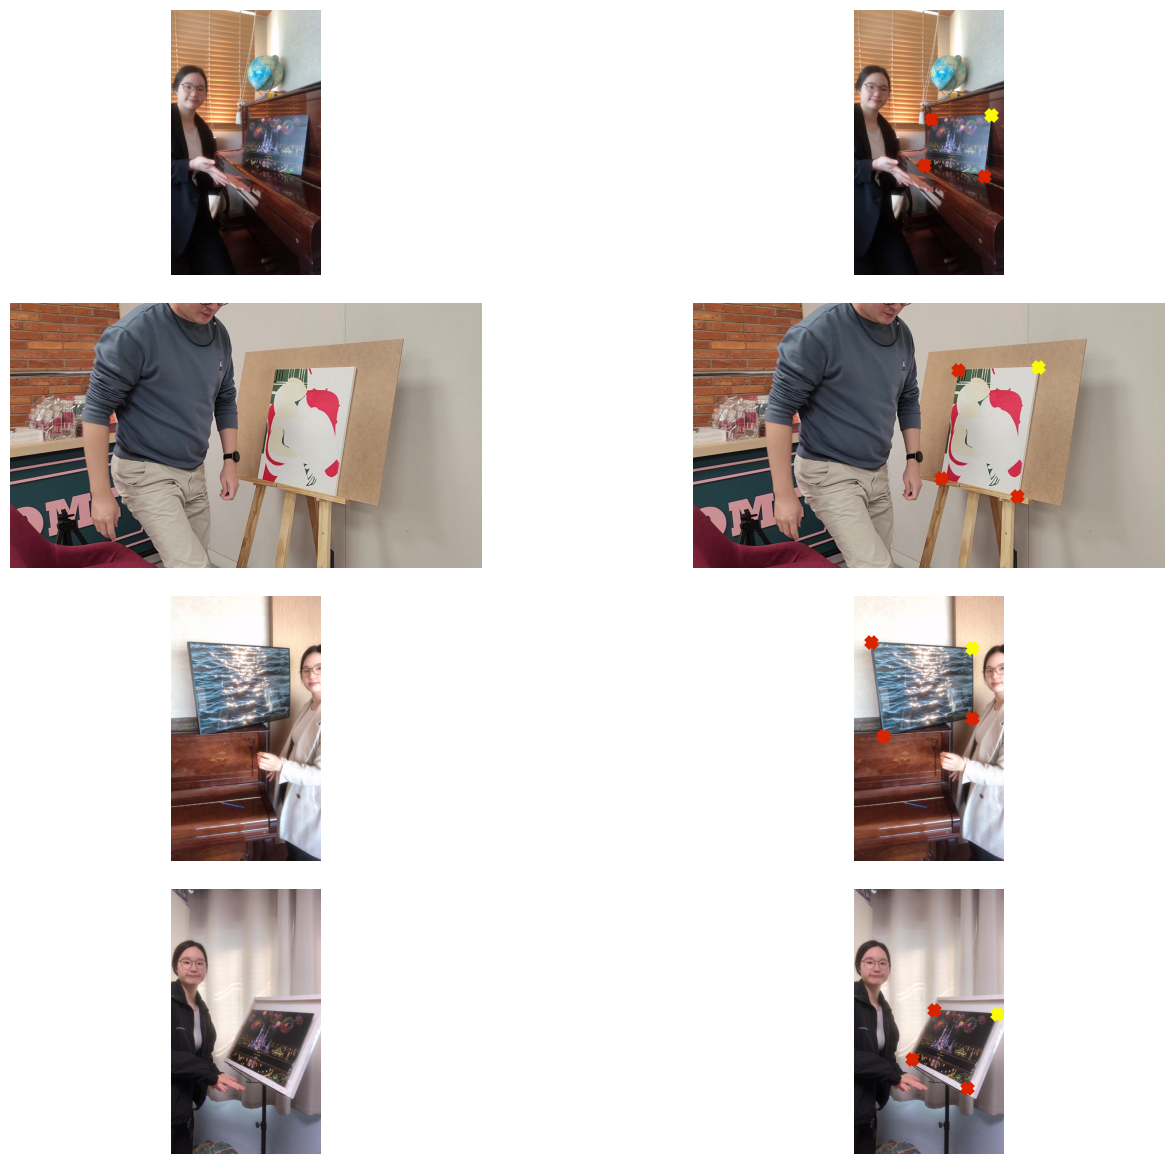

In [5]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)

            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

The plots show that we have images of non-uniform sizes, which is expected in most
real-world scenarios. However, if we resize these images to have a uniform shape (for
instance (224 x 224)) their ground-truth annotations will also be affected. The same
applies if we apply any geometric transformation (horizontal flip, for e.g.) to an image.
Fortunately, `imgaug` provides utilities that can handle this issue.
In the next section, we will write a data generator inheriting the
[`keras.utils.Sequence`](https://keras.io/api/utils/python_utils/#sequence-class) class
that applies data augmentation on batches of data using `imgaug`.

## Prepare data generator

In [6]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[
                i,
            ] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(
                kp_temp
            ).reshape(1, 1, NUM_KEYPOINTS)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

To know more about how to operate with keypoints in `imgaug` check out
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

## Define augmentation transforms

In [110]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        # iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        # iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## Create training and validation splits

In [111]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


## Data generator investigation

Total batches in training set: 21
Total batches in validation set: 3


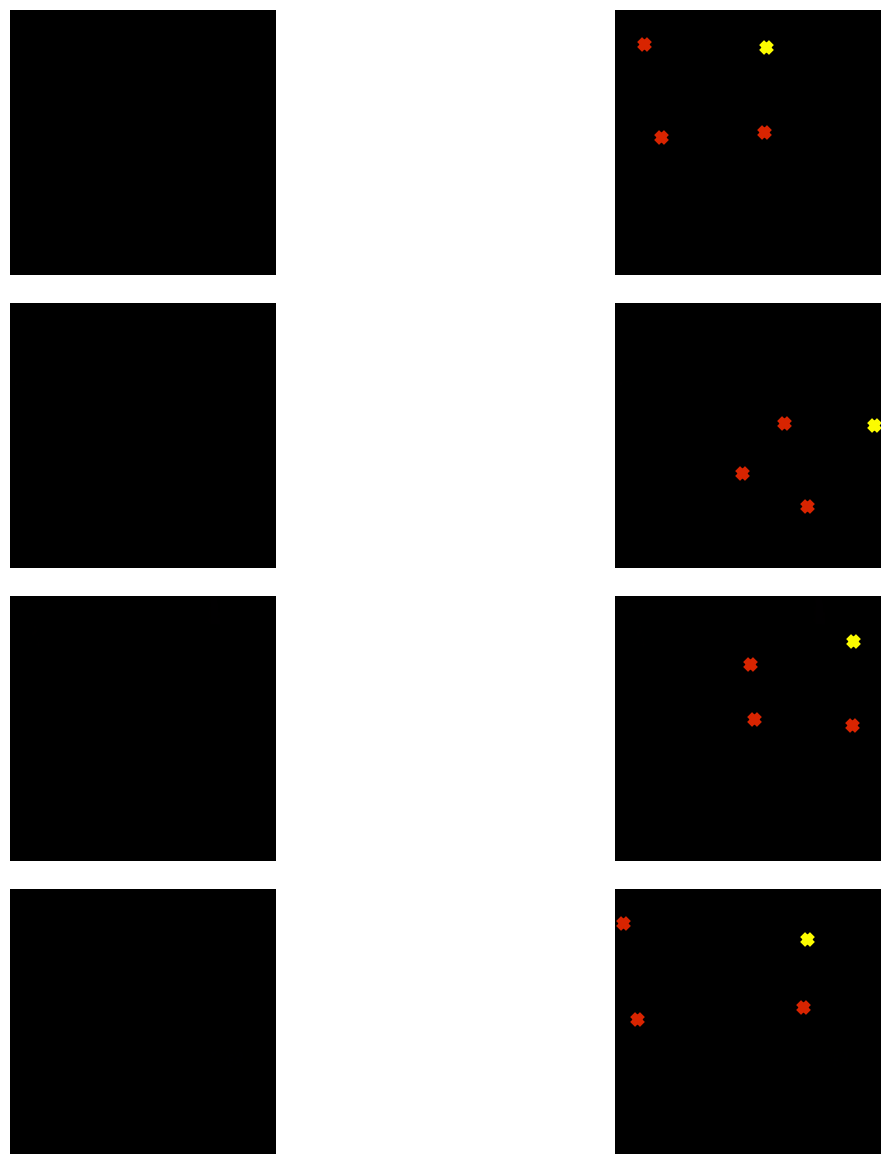

In [112]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
# assert sample_keypoints.max() == 1.0
# assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

The [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (on which
the StanfordExtra dataset is based) was built using the [ImageNet-1k dataset](http://image-net.org/).
So, it is likely that the models pretrained on the ImageNet-1k dataset would be useful
for this task. We will use a MobileNetV2 pre-trained on this dataset as a backbone to
extract meaningful features from the images and then pass those to a custom regression
head for predicting coordinates.

In [113]:

def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # backbone.trainable = False
    for layer in backbone.layers:
        layer.trainable = True

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    model = models.Sequential()
    model.add(layers.Lambda(keras.applications.resnet50.preprocess_input, name="preprocessing", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(backbone)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_KEYPOINTS, activation="sigmoid"))
    
    # x = keras.applications.resnet50.preprocess_input(inputs)
    # x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    # x = backbone(x)
    # x = layers.Dropout(0.3)(x)
    # x = layers.SeparableConv2D(
    #     NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    # )(x)
    # outputs = layers.SeparableConv2D(
    #     NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    # )(x)

    # return keras.Model(inputs, outputs, name="keypoint_detector")
    return model

Our custom network is fully-convolutional which makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.

In [114]:
get_model().summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_23 (Flatten)        (None, 100352)            0         
                                                                 
 dense_46 (Dense)            (None, 512)               51380736  
                                                                 
 batch_normalization_23 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                     

Notice the output shape of the network: `(None, 1, 1, 8)`. This is why we have reshaped
the coordinates as: `batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 4 * 2)`.

## Model compilation and training

For this example, we will train the network only for five epochs.

In [122]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/500
21/21 [==============================] - 32s 1s/step - loss: 0.1501 - val_loss: 0.4643
Epoch 2/500
21/21 [==============================] - 30s 1s/step - loss: 0.1317 - val_loss: 0.4643
Epoch 3/500
21/21 [==============================] - 31s 1s/step - loss: 0.1224 - val_loss: 0.4643
Epoch 4/500
21/21 [==============================] - 31s 1s/step - loss: 0.1117 - val_loss: 0.4643
Epoch 5/500
21/21 [==============================] - 31s 1s/step - loss: 0.0986 - val_loss: 0.4643
Epoch 6/500
21/21 [==============================] - 30s 1s/step - loss: 0.1019 - val_loss: 0.4643
Epoch 7/500
21/21 [==============================] - 30s 1s/step - loss: 0.0930 - val_loss: 0.4643
Epoch 8/500
21/21 [==============================] - 31s 1s/step - loss: 0.0872 - val_loss: 0.4643
Epoch 9/500
21/21 [==============================] - 30s 1s/step - loss: 0.0872 - val_loss: 0.4643
Epoch 10/500
21/21 [==============================] - 30s 1s/step - loss: 0.0788 - val_loss: 0.4643
Epoch 11/

## Convert model into TFLite

In [97]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory

converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.optimizations = [ tf.lite.Optimize.DEFAULT ]


tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_lng63rt/assets


INFO:tensorflow:Assets written to: /tmp/tmp_lng63rt/assets


In [98]:
# Save the TFLite model to a file
tflite_model_path = '/tf/assets/tflite/keypoint_resnet_150.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [126]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Make predictions and visualize them

In [123]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
val_image = sample_val_images
predictions_temp = model.predict(val_image)

1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 104ms/step


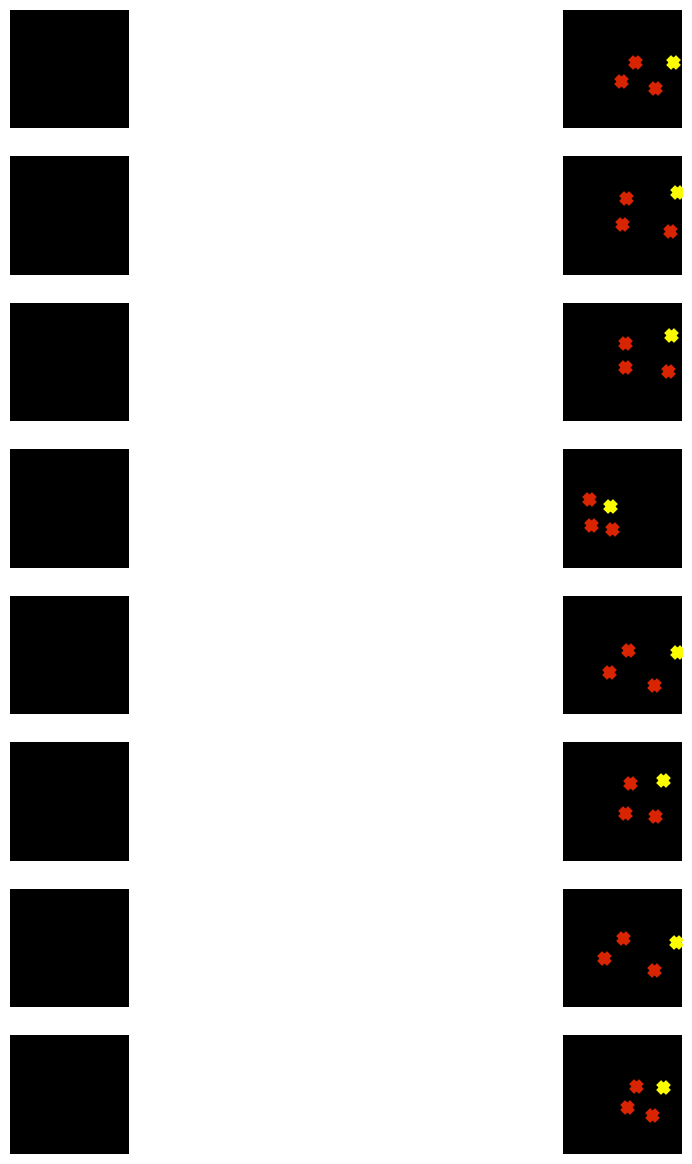

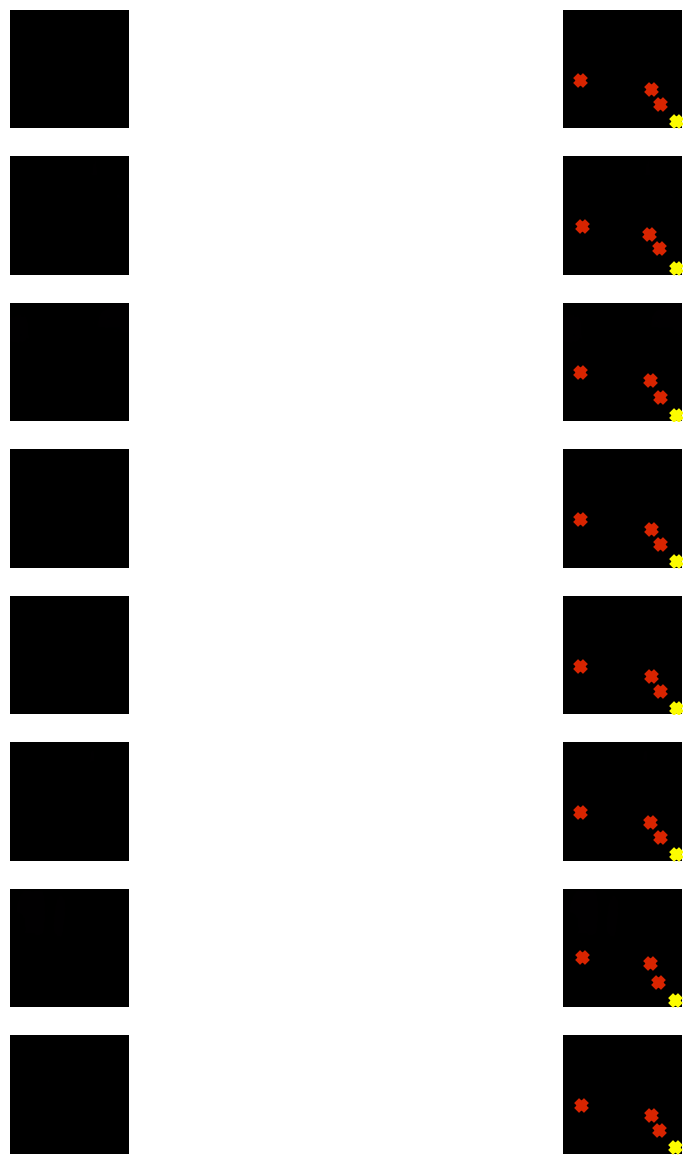

In [119]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images
sample_val_keypoints = sample_val_keypoints.reshape(-1, 4, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 4, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

Predictions will likely improve with more training.

## Going further

* Try using other augmentation transforms from `imgaug` to investigate how that changes
the results.
* Here, we transferred the features from the pre-trained network linearly that is we did
not [fine-tune](https://keras.io/guides/transfer_learning/) it. You are encouraged to fine-tune it on this task and see if that
improves the performance. You can also try different architectures and see how they
affect the final performance.